In [1]:
import matplotlib
import numpy as np

import matplotlib.pyplot as plt  # drawing heat map of attention weights

plt.rcParams['font.sans-serif'] = ['SimSun']  # set font family

In [2]:
import pickle as pkl

import numpy as np
import torch

from transformers import AutoModelForMultipleChoice, AutoTokenizer
from datasets import load_dataset

from src.utils_multiple_choice import convert_examples_to_features, InputExample

In [3]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [4]:
# Change path to local model
model_path = "../assets/models/bb_race_m/"

model = AutoModelForMultipleChoice.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

dataset = load_dataset("race", "middle")
test = dataset['test']

label_list = ["0", "1", "2", "3"]
label_map = {
    0: "A",
    1: "B",
    2: "C",
    3: "D"
}
max_seq_length = 128

Reusing dataset race (/home/marcos/.cache/huggingface/datasets/race/middle/0.1.0/a7d1fac780e70c0e75bca35e9f2f8cfc1411edd18ffd6858ddce56f70dfb1e7c)


In [5]:
def predict(article, question, options, real_label=None, return_result=False):
    examples = [InputExample(
        example_id="pred",
        question=question,
        contexts=[article, article, article, article],  # this is not efficient but convenient
        endings=[options[0], options[1], options[2], options[3]],
        label=str(ord(real_label) - ord("A")) if real_label else "0"
    )]
    
    feature = convert_examples_to_features(
        examples,
        label_list,
        max_seq_length,
        tokenizer
    )[0]
    
    features = {
        'input_ids': torch.tensor([feature.input_ids]),
        'attention_mask': torch.tensor([feature.attention_mask]),
        'token_type_ids': torch.tensor([feature.token_type_ids]),
    } 
    
    if return_result:
        result = model.forward(features['input_ids'], features['attention_mask'], features['token_type_ids'], 
                               output_attentions=True, output_hidden_states=True, return_dict=True)
        return result
    else:
        result = model.forward(features['input_ids'], features['attention_mask'], features['token_type_ids'])[0][0]
        return np.array([float(abs(x)) for x in result]).argmax()

In [6]:
def plot_heatmap(ex):
    for option in range(4):
        atts, tokens, option_start = get_atts(ex, option=option)
        data = []
        for word_q in range(option_start):
            data.append(np.sum([atts[0][0][i][word_q][option_start:-1] for i in range(len(atts[0][0]))]).detach().numpy())

        data = np.array(data)

        fig, ax = plt.subplots(figsize=(20, 8))  # set figure size
        heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)

        X_label = tokens[option_start:]
        xticks = range(0, len(X_label))
        ax.set_xticks(xticks, minor=False)  # major ticks
        ax.set_xticklabels(X_label, minor=False, rotation=45)  # labels should be 'unicode'

        Y_label = tokens[:option_start]
        yticks = range(0, len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor=False)  # labels should be 'unicode'

        ax.grid(True)

        plt.title(f'Attention Heatmap for Option {option}')
        plt.show()


In [7]:
def get_atts(ex, option):
    examples = [InputExample(
        example_id="pred",
        question=ex['question'],
        contexts=[ex['article'], ex['article'], ex['article'], ex['article']],  # this is not efficient but convenient
        endings=[ex['options'][0], ex['options'][1], ex['options'][2], ex['options'][3]],
        label=str(ord(ex['answer']) - ord("A")) if ex['answer'] else "0"
    )]
    
    feature = convert_examples_to_features(
        examples,
        label_list,
        max_seq_length,
        tokenizer
    )[0]
    
    features = {
        'input_ids': torch.tensor([feature.input_ids]),
        'attention_mask': torch.tensor([feature.attention_mask]),
        'token_type_ids': torch.tensor([feature.token_type_ids]),
    } 
    input_id_list = feature.input_ids[option]
    tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
    token_type_ids = feature.token_type_ids
    
    attention = model.forward(features['input_ids'], features['attention_mask'], features['token_type_ids'], 
                               output_attentions=True, output_hidden_states=True, return_dict=True)['attentions']
    
    q_start = token_type_ids[option].index(1)
    option_start = len(tokenizer.tokenize(ex['question'])[:-2])
    tokens_ = tokens[q_start:]
    atts = []
    for att in attention:

        atts.append(att[option].reshape(1, 12, 128, 128)[:, :, q_start:, q_start:])

    return atts, tokens_, option_start

### Example 1

In [8]:
ex1 = test[0]

ex1_article = ex1['article']
ex1_question = ex1['question']
ex1_options = ex1['options']
ex1_real_label = ex1['answer']

result = predict(ex1_article, ex1_question, ex1_options, ex1_real_label)
print(f"Question: {ex1_question}")
print(f"Options: {ex1_options}")
print(f"Result: {label_map[result]}")

convert examples to features: 1it [00:00, 70.41it/s]


Question: A discipline leader is supposed to  _  .
Options: ['take care of the whole group', 'make sure that everybody finishes homework', 'make sure that nobody chats in class', 'collect all the homework and hand it in to teachers']
Result: C


In [9]:
result = predict(ex1_article, ex1_question, ex1_options, ex1_real_label, return_result=True)

convert examples to features: 1it [00:00, 56.81it/s]


##### Modification A

In [10]:
ex1_modA_question = "What is a discipline leader supposed to?"

result = predict(ex1_article, ex1_modA_question, ex1_options, ex1_real_label)
print(f"Question: {ex1_modA_question}")
print(f"Options: {ex1_options}")
print(f"Result: {label_map[result]}")

ex1_mod_a = {
    'article': ex1_article,
    'question': ex1_modA_question,
    'options': ex1_options,
    'answer': ex1_real_label
}

convert examples to features: 1it [00:00, 83.93it/s]


Question: What is a discipline leader supposed to?
Options: ['take care of the whole group', 'make sure that everybody finishes homework', 'make sure that nobody chats in class', 'collect all the homework and hand it in to teachers']
Result: A


##### Modification B

In [11]:
ex1_modB_question = "What is a discipline leader?"
ex1_modB_options = [
    "A person supposed to take care of the whole group",
    "A person supposed to make sure that everybody finished homework",
    "A person supposed to make sure that nobody chats in class",
    "A person supposed to collect all the homework and hand it in to teachers"
]

result = predict(ex1_article, ex1_modB_question, ex1_modB_options, ex1_real_label)
print(f"Question: {ex1_modB_question}")
print(f"Options: {ex1_modB_options}")
print(f"Result: {label_map[result]}")

ex1_mod_b = {
    'article': ex1_article,
    'question': ex1_modB_question,
    'options': ex1_modB_options,
    'answer': ex1_real_label
}

convert examples to features: 1it [00:00, 81.56it/s]


Question: What is a discipline leader?
Options: ['A person supposed to take care of the whole group', 'A person supposed to make sure that everybody finished homework', 'A person supposed to make sure that nobody chats in class', 'A person supposed to collect all the homework and hand it in to teachers']
Result: B


##### Modification C

In [12]:
ex1_modC_question = "What is an orderliness leader?"
ex1_modC_options = [
    "A person supposed to take care of the whole group",
    "A person supposed to make sure that everybody finished homework",
    "A person supposed to make sure that nobody chats in class",
    "A person supposed to collect all the homework and hand it in to teachers"
]
result = predict(ex1_article, ex1_modC_question, ex1_modC_options, ex1_real_label)
print(f"Question: {ex1_modC_question}")
print(f"Options: {ex1_modC_options}")
print(f"Result: {label_map[result]}")

ex1_mod_c = {
    'article': ex1_article,
    'question': ex1_modC_question,
    'options': ex1_modC_options,
    'answer': ex1_real_label
}

convert examples to features: 1it [00:00, 82.22it/s]


Question: What is an orderliness leader?
Options: ['A person supposed to take care of the whole group', 'A person supposed to make sure that everybody finished homework', 'A person supposed to make sure that nobody chats in class', 'A person supposed to collect all the homework and hand it in to teachers']
Result: C


### Example 2

In [13]:
ex2 = test[86]

ex2_article = ex2['article']
ex2_question = ex2['question']
ex2_options = ex2['options']
ex2_real_label = ex2['answer']

result = predict(ex2_article, ex2_question, ex2_options, ex2_real_label)
print(f"Question: {ex2_question}")
print(f"Options: {ex2_options}")
print(f"Real answer: {ex2_real_label}")

convert examples to features: 1it [00:00, 99.05it/s]


Question: Where did the traveler come from?
Options: ['England', 'America', 'Canada', 'France']
Real answer: B


##### Mod a

In [14]:
ex2_modA_question = "The traveler came from _ ."

result = predict(ex2_article, ex2_modA_question, ex2_options, ex2_real_label)
print(f"Question: {ex2_modA_question}")
print(f"Options: {ex2_options}")
print(f"Result: {label_map[result]}")

ex2_mod_a = {
    'article': ex2_article,
    'question': ex2_modA_question,
    'options': ex2_options,
    'answer': ex2_real_label
}

convert examples to features: 1it [00:00, 99.79it/s]


Question: The traveler came from _ .
Options: ['England', 'America', 'Canada', 'France']
Result: C


##### Mod b

In [15]:
ex2_modB_question = "The traveler _ ."
ex2_modB_options = [
    "came from England",
    "came from America",
    "came from Canada",
    "came from France"
]

result = predict(ex2_article, ex2_modB_question, ex2_modB_options, ex2_real_label)
print(f"Question: {ex2_modB_question}")
print(f"Options: {ex2_modB_options}")
print(f"Result: {label_map[result]}")

ex2_mod_b = {
    'article': ex2_article,
    'question': ex2_modB_question,
    'options': ex2_modB_options,
    'answer': ex2_real_label
}

convert examples to features: 1it [00:00, 98.26it/s]


Question: The traveler _ .
Options: ['came from England', 'came from America', 'came from Canada', 'came from France']
Result: C


##### Mod c

In [16]:
ex2_modC_question = "The visitor _ ."
ex2_modC_options = [
    "came from England",
    "came from America",
    "came from Canada",
    "came from France"
]

result = predict(ex2_article, ex2_modC_question, ex2_modC_options, ex2_real_label)
print(f"Question: {ex2_modC_question}")
print(f"Options: {ex2_modC_options}")
print(f"Result: {label_map[result]}")

ex2_mod_c = {
    'article': ex2_article,
    'question': ex2_modC_question,
    'options': ex2_modC_options,
    'answer': ex2_real_label
}

convert examples to features: 1it [00:00, 99.41it/s]


Question: The visitor _ .
Options: ['came from England', 'came from America', 'came from Canada', 'came from France']
Result: C


### Example 3

In [17]:
ex3 = test[17]

ex3_article = ex3['article']
ex3_question = ex3['question']
ex3_options = ex3['options']
ex3_real_label = ex3['answer']

result = predict(ex3_article, ex3_question, ex3_options, ex3_real_label)
print(f"Article: {ex3_article}")
print(f"Question: {ex3_question}")
print(f"Options: {ex3_options}")
print(f"Prediction: {label_map[result]}")
print(f"Real answer: {ex3_real_label}")

convert examples to features: 1it [00:00, 170.71it/s]


Article: It's the second time for me to come to Beijing. There are many places of interest in Beijing, such as the Summer Palace, the Great Wall, etc. What's more, I think great changes have taken place in Beijing. People's living conditions have improved a lot. Their life is very happy. Almost everyone has a big smile on the face. People in Beijing are in high spirits and hard-working. Children can receive a good education.
But in the past, some children didn't have enough money to go to school. They often worked for cruel bosses. The bosses didn't give them enough food. I feel sorry for them. Today people have already lived in tall building, worn beautiful clothes and so on. Life has changed greatly.
Question: In the past, children had   _   education.
Options: ['enough', 'high', 'good', 'bad']
Prediction: D
Real answer: D


##### Mod a

In [18]:
ex3_modA_question = "How was the children education in the past?"

result = predict(ex3_article, ex3_modA_question, ex3_options, ex3_real_label)
print(f"Question: {ex3_modA_question}")
print(f"Options: {ex3_options}")
print(f"Result: {label_map[result]}")

ex3_mod_a = {
    'article': ex3_article,
    'question': ex3_modA_question,
    'options': ex3_options,
    'answer': ex3_real_label
}

convert examples to features: 1it [00:00, 171.23it/s]


Question: How was the children education in the past?
Options: ['enough', 'high', 'good', 'bad']
Result: D


##### Mod b

In [19]:
ex3_modB_question = "In the past, children had _ ."
ex3_modB_options = [
 "enough education",
 "high education",
 "good education",
 "bad education"
]

result = predict(ex3_article, ex3_modB_question, ex3_modB_options, ex3_real_label)
print(f"Question: {ex3_modB_question}")
print(f"Options: {ex3_modB_options}")
print(f"Result: {label_map[result]}")

ex3_mod_b = {
    'article': ex3_article,
    'question': ex3_modB_question,
    'options': ex3_modB_options,
    'answer': ex3_real_label
}

convert examples to features: 1it [00:00, 168.93it/s]


Question: In the past, children had _ .
Options: ['enough education', 'high education', 'good education', 'bad education']
Result: D


##### Mod c

In [20]:
ex3_modC_question = "In the past, kids had _ ."
ex3_modC_options = [
 "enough education",
 "high education",
 "good education",
 "bad education"
]

result = predict(ex3_article, ex3_modC_question, ex3_modC_options, ex3_real_label)
print(f"Question: {ex3_modC_question}")
print(f"Options: {ex3_modC_options}")
print(f"Result: {label_map[result]}")

ex2_mod_c = {
    'article': ex3_article,
    'question': ex3_modC_question,
    'options': ex3_modC_options,
    'answer': ex3_real_label
}

convert examples to features: 1it [00:00, 165.70it/s]


Question: In the past, kids had _ .
Options: ['enough education', 'high education', 'good education', 'bad education']
Result: D


### Visualization

convert examples to features: 1it [00:00, 83.31it/s]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


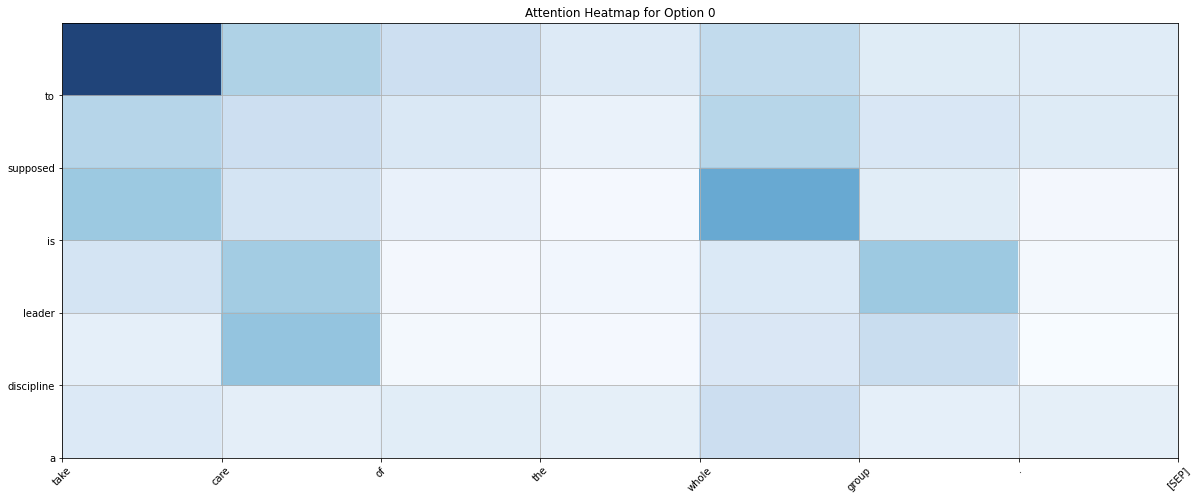

convert examples to features: 1it [00:00, 82.98it/s]


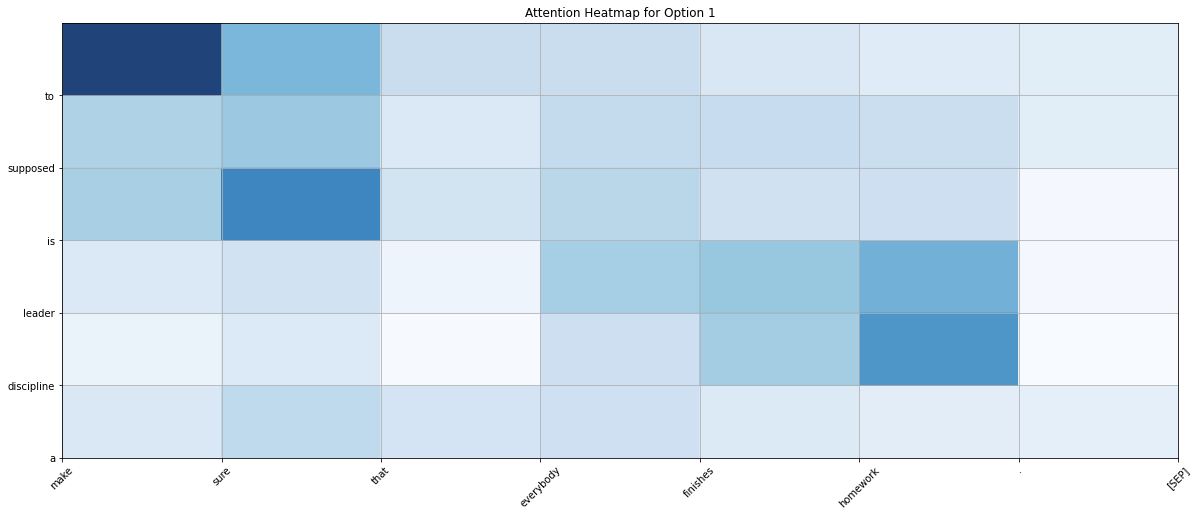

convert examples to features: 1it [00:00, 79.79it/s]


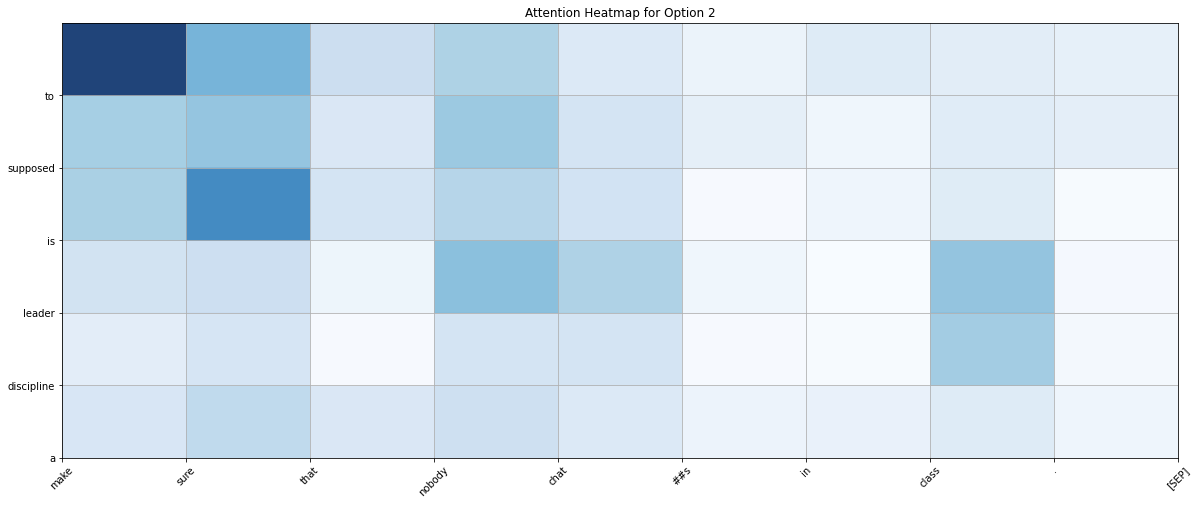

convert examples to features: 1it [00:00, 83.00it/s]


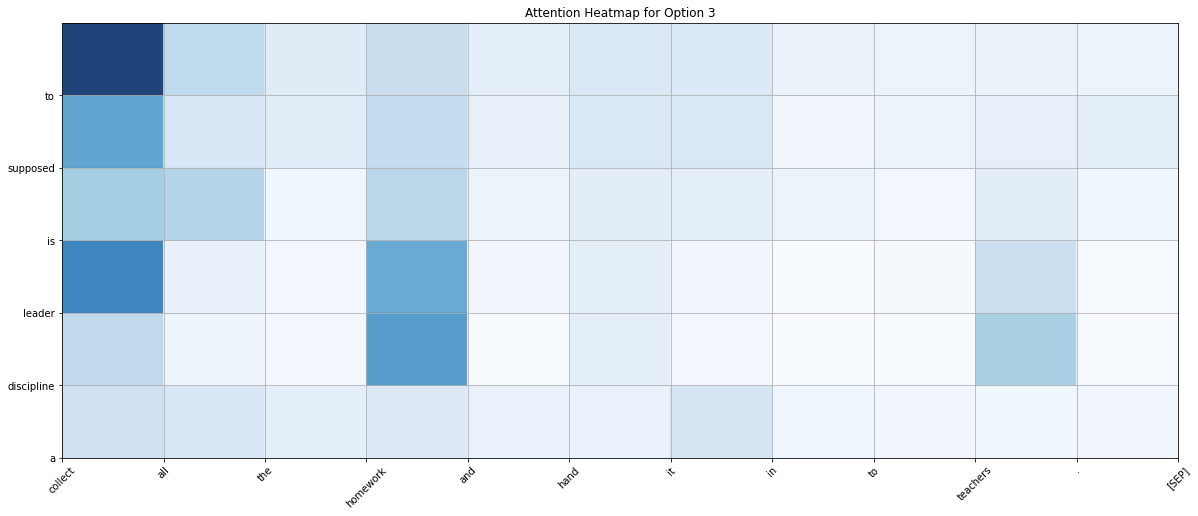

In [21]:
# Select example fromm:
# ex1 - ex1_mod_a - ex1_mod_b - ex1_mod_c
# ex2 - ex2_mod_a - ex2_mod_b - ex2_mod_c
# ex3 - ex3_mod_a - ex3_mod_b - ex3_mod_c
example_to_show = ex1

plot_heatmap(example_to_show)